# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_valid_data = []
    new_valid_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_valid_data.append(validset.data[np.where(np.array(validset.targets) == t)])
        new_valid_labels += [i for _ in range(new_valid_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_valid_data = np.concatenate(new_valid_data, 0)
    validset.data = new_valid_data
    validset.targets = new_valid_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
valid_data_iter = iter(validloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
used classes: ['cat', 'dog']


In [4]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))

print("\n# valid data")
print("Number of points:", len(validset))
x, y = next(iter(validloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(validset.targets)))

print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2

# valid data
Number of points: 2000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2

# Test data
Number of points: 2000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2


Let us show some of the training images, for fun.



  dog   cat   cat   cat


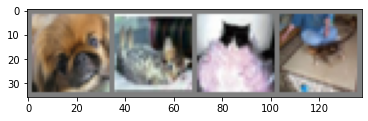

In [5]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = test_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

input_channels = 3
input_height = 32
input_width = 32

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes

        # Your code here!
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=16,
                               kernel_size=5,
                               padding = 2)
        self.bn1 = nn.BatchNorm2d(num_features=16) 

        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32,
                               kernel_size=5,
                               padding=2)
        #self.conv2_drop = nn.Dropout2d()
        self.bn2 = nn.BatchNorm2d(num_features=32) 

        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=5,
                               padding =2)
        self.bn3 = nn.BatchNorm2d(num_features=64) 


        # fully connected output layers
        self.fc1_features = 64 * input_height//2//2//2* input_width//2//2//2
        self.fc1 = nn.Linear(in_features=self.fc1_features, 
                             out_features=50)
        self.fc2 = nn.Linear(in_features=50,
                             out_features=num_classes)

    def forward(self, x):
        # Your code here!

        #print(x.size())
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        #print(x.size())
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        #print(x.size())
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)), 2))
        #print(x.size())

        x = x.view(-1, self.fc1_features)
        #print(x.size())
        x = F.relu(self.fc1(x))
        # note use of Functional.dropout, where training must be explicitly defined (default: False)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
  

net = Net(len(used_categories))
net.cuda()
print(net)

x = np.random.normal(0,1, (4, 3, 32, 32)).astype('float32')
x = Variable(torch.from_numpy(x))
x = x.cuda()
out = net(x)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=3e-4)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0) # Your code here!

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

[1,  1000] loss: 0.689
[1,  2000] loss: 0.669
Epoch  1 : Train acc 0.654800, Valid acc 0.672000
[2,  1000] loss: 0.644
[2,  2000] loss: 0.649
Epoch  2 : Train acc 0.695100, Valid acc 0.693500
[3,  1000] loss: 0.616
[3,  2000] loss: 0.594
Epoch  3 : Train acc 0.692200, Valid acc 0.670000
[4,  1000] loss: 0.576
[4,  2000] loss: 0.586
Epoch  4 : Train acc 0.739200, Valid acc 0.707000
[5,  1000] loss: 0.540
[5,  2000] loss: 0.545
Epoch  5 : Train acc 0.773900, Valid acc 0.746500
[6,  1000] loss: 0.508
[6,  2000] loss: 0.503
Epoch  6 : Train acc 0.767500, Valid acc 0.753000
[7,  1000] loss: 0.475
[7,  2000] loss: 0.479
Epoch  7 : Train acc 0.824800, Valid acc 0.761000
[8,  1000] loss: 0.432
[8,  2000] loss: 0.450
Epoch  8 : Train acc 0.842400, Valid acc 0.772000
[9,  1000] loss: 0.400
[9,  2000] loss: 0.418
Epoch  9 : Train acc 0.856800, Valid acc 0.780500
[10,  1000] loss: 0.364
[10,  2000] loss: 0.386
Epoch 10 : Train acc 0.877300, Valid acc 0.784000
Finished Training


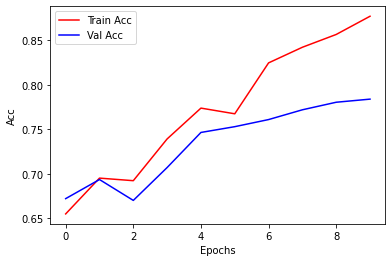

In [8]:
from sklearn.metrics import accuracy_score
num_epoch = 10  # Your code here!


train_acc = []
valid_acc = []

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0

    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        batch_loss = criterion(output,labels)
        batch_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += batch_loss
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        output = net(inputs)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(labels.cpu().data.numpy())
        train_preds += list(preds.cpu().data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i, data in enumerate(validloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        output = net(inputs)
        preds = torch.max(output, 1)[1]
        
        val_targs += list(labels.cpu().data.numpy())
        val_preds += list(preds.cpu().data.numpy())

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)

    print("Epoch %2i : Train acc %f, Valid acc %f" % (
            epoch+1, train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))       
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

print('Finished Training')

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

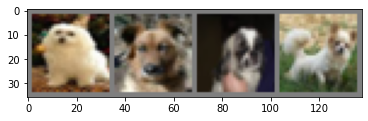

GroundTruth:     dog   dog   dog   dog
Predicted:       dog   dog   dog   dog


In [9]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.cuda())
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [10]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 2000 test images: 78.40 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [11]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu() == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cat   : 86.20 %
Accuracy of dog   : 70.60 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

Experiments:

1. Use two convolution layers, each is followed with a max pooling. two fully connected layers. $\rightarrow$ loss almost doesn't decrease.

2. Add a batch normalization layer after each convolution layer.$\rightarrow$ No big changes.

3. Change the learning rate of optimazer; Change SGD to Adam $\rightarrow$ No big changes.

4. Change the network structure by adding a third conv layer. $\rightarrow$ loss decreases quickly!

5. Try more epochs. Tansfer the net and variables to GPU $\rightarrow$ the test accuray can increase up to 75%, but then overfitting.

6. Do data visualization by adding evaluation part to find the exact epoch which start overfitting

7. Add weight decay and dropout to avoid overfitting. $\rightarrow$ The final accuracy is 78.4%

Insights:

1. The stucture of CNN is very important, deeper network can work better in this task.
2. If our model has high training error (high bias), we should try a bigger netowrk or longer trainning time. If our model has big difference between trainging and testing error (overfitting,high variance), we should consider some tricks like regularization, dropout, or early stopping by doing data visualization to find the exact number of training epoch.
3. Learning rate is an important parameter, especially for SGD algorithm.(I don't know why but SGD doesn't work very well in my experiment).

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

Exercise of chapter 3

1.Verify that $\sigma'(z)=\sigma(z)(1-\sigma(z))$

**Answer:**
We know that:
$$
\sigma(z) = \frac{1}{1+e^{-z}}\\
1-\sigma(z) = \frac{e^{-z}}{1+e^{-z}}
$$
So:
$$
\sigma'(z) = \frac{e^{-z}}{(1+e^{-z})^2} = \frac{1}{1+e^{-z}} \cdot \frac{e^{-z}}{1+e^{-z}} =\sigma(z)(1-\sigma(z))
$$


2.One gotcha with the cross-entropy is that it can be difficult at first to remember the respective roles of the ys and the as. It's easy to get confused about whether the right form is 
$−[ylna+(1−y)ln(1−a)]$ or $−[alny+(1−a)ln(1−y)]$. What happens to the second of these expressions when y=0 or 1? Does this problem afflict the first expression? Why or why not?

**Answer:**
The second requires that y can't be 0 or 1 since $lny$ or $ln(1-y)$ would be invalid. This problem would not happen in the frist expression because $a$ is the out put of Sigmoid funtion, which can only infinitely close to 0 or 1, but can never equal to 0 or 1.

3.In the single-neuron discussion at the start of this section, I argued that the cross-entropy is small if $σ(z)≈y$ for all training inputs. The argument relied on y being equal to either 0 or 1. This is usually true in classification problems, but for other problems (e.g., regression problems) y can sometimes take values intermediate between 0 and 1. Show that the cross-entropy is still minimized when $σ(z)=y$ for all training inputs.

**Answer:**
Compute the derivative of cross-entropy with respect to $a$:
$$
C' = −[ylna+(1−y)ln(1−a)]'=-(\frac{y}{a} - \frac{1-y}{1-a})
$$
To get the minimal value, let $C'=0$:

\begin{align}
 \Rightarrow& -(\frac{y}{a} - \frac{1-y}{1-a})=0\\
\Rightarrow & \frac{y}{a} = \frac{1-y}{1-a}\\
\Rightarrow & y-ay = a-ay\\
\Rightarrow & a =y\\
\end{align}
